# Diffusion on a Cartesian grid

This example shows how to solve the diffusion equation on a Cartesian grid.


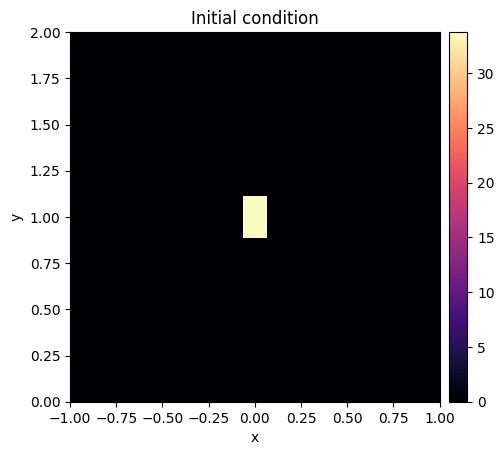

  0%|          | 0/1.0 [00:00<?, ?it/s]

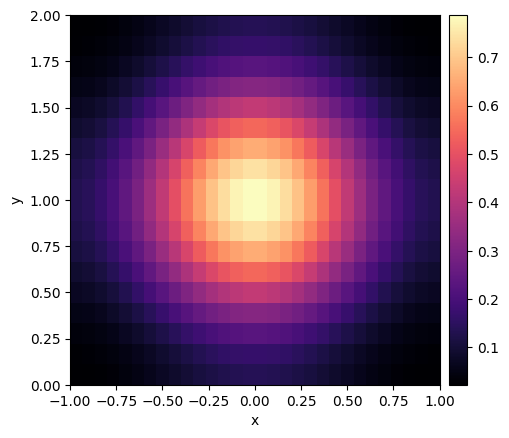

In [1]:
from pde import CartesianGrid, DiffusionPDE, ScalarField

grid = CartesianGrid([[-1, 1], [0, 2]], [30, 18])  # generate grid
state = ScalarField(grid)  # generate initial condition
state.insert([0, 1], 1)
state.plot(title="Initial condition", cmap="magma")
eq = DiffusionPDE(0.1)  # define the pde
result_pdepde = eq.solve(state, t_range=1, dt=0.001)
result_pdepde.plot(cmap="magma")
result_pdepde = result_pdepde.data

0.06666666666666667 0.1111111111111111


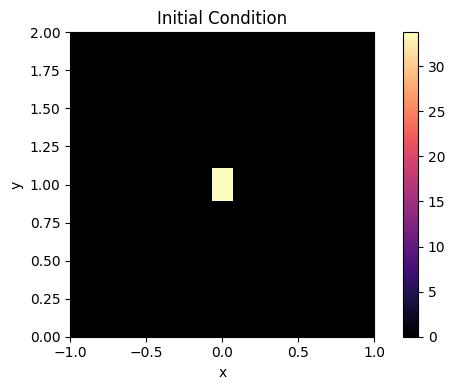

mu_x=0.011, mu_y=0.004


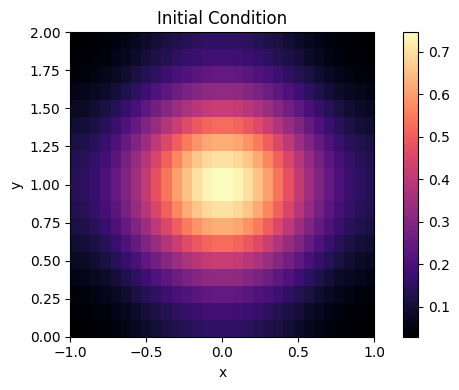

✅ Total mass after diffusion: 1.000000 (should be close to 1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PyMPDATA import ScalarField, VectorField, Stepper, Solver, Options
from PyMPDATA.boundary_conditions import Periodic

# ------------------------
# Physical and grid config
# ------------------------
D = 0.1       # Diffusion coefficient
dt = 0.001     # Time step size
t_end = 2
nx, ny = 30, 18
min_x, max_x = -1.0, 1.0
min_y, max_y =  0.0, 2.0

dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
print(dx, dy)
n_steps = int(t_end / dt)  # Number of time steps

# ------------------------
# Grid: physical coordinates
# ------------------------
x = np.linspace(min_x + dx/2, max_x - dx/2, nx)
y = np.linspace(min_y + dy/2, max_y - dy/2, ny)

# ------------------------
# Gaussian blob initializer
# ------------------------
def init_py_pde_like_pulse():
    data = np.zeros((nx, ny))

    # Locate cell nearest (0, 1)
    i = np.argmin(np.abs(x - 0.0))
    j = np.argmin(np.abs(y - 1.0))

    # Distribute mass over 2x2 cells (py-pde seems to do this internally)
    mass_per_cell = 1.0 / (4 * dx * dy)
    data[i,   j]     = mass_per_cell
    data[i+1, j]     = mass_per_cell
    data[i,   j+1]   = mass_per_cell
    data[i+1, j+1]   = mass_per_cell

    return data
# ------------------------
# Options and stepper
# ------------------------
opt = Options(n_iters=2, non_zero_mu_coeff=True)
stepper = Stepper(options=opt, n_dims=2)
halo = opt.n_halo  # Get required halo size

# ------------------------
# Initialize scalar field
# ------------------------
data = init_py_pde_like_pulse()
data_mpdata = data
advectee = ScalarField(data=data, halo=halo, boundary_conditions=(Periodic(), Periodic()))

# ------------------------
# No advection, so velocities are 0
# ------------------------
Cx = np.zeros((nx + 1, ny), dtype=opt.dtype)
Cy = np.zeros((nx, ny + 1), dtype=opt.dtype)
advector = VectorField(data=(Cx, Cy), halo=halo, boundary_conditions=(Periodic(), Periodic()))

# ------------------------
# Create solver
# ------------------------
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

# ------------------------
# Plot initial blob
# ------------------------
plt.figure(figsize=(6, 4))
plt.imshow(solver.advectee.get().T, cmap='magma', origin='lower',
           extent=[min_x, max_x, min_y, max_y])
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.tight_layout()
plt.show()

# ------------------------
# Run the simulation
# ------------------------
mu_x = (D * dt / dx**2)/2
mu_y = (D * dt / dy**2)/2
print(f"mu_x={mu_x:.3f}, mu_y={mu_y:.3f}")
solver.advance(n_steps=n_steps, mu_coeff=(mu_x, mu_y))
result_mpdata = solver.advectee.get()
# ------------------------
# Plot final result
# ------------------------
plt.figure(figsize=(6, 4))
plt.imshow(solver.advectee.get().T, cmap='magma', origin='lower',
           extent=[min_x, max_x, min_y, max_y])
plt.title("Initial Condition")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.tight_layout()
plt.show()

# ------------------------
# Total mass check
# ------------------------
mass = np.sum(solver.advectee.get()) * dx * dy
print(f"✅ Total mass after diffusion: {mass:.6f} (should be close to 1)")

In [3]:
from numpy import linalg as LA


diff = result_mpdata - result_pdepde
rmse = np.sqrt(np.mean(diff**2))
l1   = np.sum(np.abs(diff)) * dx * dy
mass_py_pde = result_pdepde.sum() * dx * dy
mass_mpdata = result_mpdata.sum() * dx * dy
print("💧 Total mass:")
print(f"✔️ py-pde:    {mass_py_pde:.6f}")
print(f"✔️ PyMPDATA:  {mass_mpdata:.6f}")

print(f"RMSE: {rmse:.6f}, L1 Error: {l1:.6f}")

💧 Total mass:
✔️ py-pde:    1.000000
✔️ PyMPDATA:  1.000000
RMSE: 0.014117, L1 Error: 0.044372


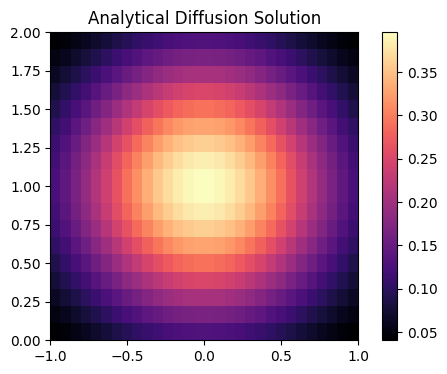

PDE vs analytical:
RMSE vs analytical: 0.121742
L1 Error vs analytical: 0.297262 

MPDATA vs analytical:
RMSE vs analytical: 0.109908
L1 Error vs analytical: 0.269922


In [4]:
def analytical_solution(x, y, t, D=0.1, center=(0.0, 1.0)):
    x0, y0 = center
    r2 = (x - x0) ** 2 + (y - y0) ** 2
    return (1 / (4 * np.pi * D * t)) * np.exp(-r2 / (4 * D * t))

X, Y = np.meshgrid(x, y, indexing="ij")
u_exact = analytical_solution(X, Y, t_end, D=D)

plt.figure(figsize=(6, 4))
plt.imshow(u_exact.T, origin='lower', extent=[min_x, max_x, min_y, max_y], cmap='magma')
plt.title("Analytical Diffusion Solution")
plt.colorbar()
plt.show()

diff = result_pdepde - u_exact
rmse = np.sqrt(np.mean((diff)**2))
l1_error = np.sum(np.abs(diff)) * dx * dy

print("PDE vs analytical:")
print(f"RMSE vs analytical: {rmse:.6f}")
print(f"L1 Error vs analytical: {l1_error:.6f} \n")

diff = result_mpdata - u_exact
rmse = np.sqrt(np.mean((diff)**2))
l1_error = np.sum(np.abs(diff)) * dx * dy

print("MPDATA vs analytical:")
print(f"RMSE vs analytical: {rmse:.6f}")
print(f"L1 Error vs analytical: {l1_error:.6f}")